In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [2]:
# Set random seeds for reproducibility
torch.set_num_threads(4) 

data = pd.read_csv('../datasets/meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()


def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data['Close'])  


data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,25.546291,27.046144,28.449746,30.538853,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,24.267527,26.075936,27.807865,30.192623,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,23.138351,25.131220,27.148068,29.827422,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,22.105568,24.205544,26.471110,29.443602,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,21.767045,23.639081,25.958623,29.116010,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,68.007206,67.283914,66.478537,64.769416,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,68.428138,67.645020,66.744391,64.945909,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,69.382092,68.307744,67.177306,65.194697,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,71.248061,69.520881,67.920420,65.578435,71.536342


In [3]:
# Select key features
selected_features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA for 5 days', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days',
    'EMA for 5 days', 'EMA for 10 days', 'EMA for 20 days', 'EMA for 50 days',
    'RSI_14'
]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[selected_features])

# Create sequences with reduced length
sequence_length = 30  # Reduced from 60
X = []
y = []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length, 0])

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader with larger batch size
batch_size = 128  # Increased batch size
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)



In [4]:
from torch.optim.lr_scheduler import StepLR

# Create data loaders
batch_size = 256
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)


class EfficientStockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model)
        
        # Simplified Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,  # Reduced feedforward dimension
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Single-layer LSTM
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,  # Single layer
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.output_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_norm(self.input_projection(x))
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.output_norm(x)
        x = self.fc(x)
        
        return x

def train_efficient_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.MSELoss()  
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01
    )
    
    # step scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=5,
        gamma=0.5
    )
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    training_losses = []
    validation_losses = []

    # History dictionary to store metrics
    history = {
        'training_losses': [],
        'validation_losses': [],
        'learning_rates': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()

        # Get current learning rate before stepping the scheduler
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        
        scheduler.step()
        
        avg_train_loss = total_train_loss / len(train_loader)
        history['training_losses'].append(avg_train_loss)

        
        # Validation phase
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {avg_train_loss:.6f} - '
              f'Val Loss: {avg_val_loss:.6f} - '
              f'LR: {current_lr:.6f}')

        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
    
    # Save the final history
    import pickle
    with open('model_history.pkl', 'wb') as f:
        pickle.dump(history, f)
    
    # Save as JSON
    import json
    with open('model_history.json', 'w') as f:
        json.dump(history, f)
        
    return history

# Usage
input_dim = len(selected_features)
model = EfficientStockPredictor(input_dim=input_dim)
history = train_efficient_model(model, train_loader, val_loader)

# training_losses, validation_losses = train_efficient_model(model, train_loader, val_loader)






Epoch [1/30] - Train Loss: 0.668796 - Val Loss: 0.068494 - LR: 0.001000
Epoch [2/30] - Train Loss: 0.035592 - Val Loss: 0.021534 - LR: 0.001000
Epoch [3/30] - Train Loss: 0.010394 - Val Loss: 0.013221 - LR: 0.001000
Epoch [4/30] - Train Loss: 0.003910 - Val Loss: 0.010968 - LR: 0.001000
Epoch [5/30] - Train Loss: 0.001931 - Val Loss: 0.006524 - LR: 0.001000
Epoch [6/30] - Train Loss: 0.000985 - Val Loss: 0.005341 - LR: 0.000500
Epoch [7/30] - Train Loss: 0.000845 - Val Loss: 0.002972 - LR: 0.000500
Epoch [8/30] - Train Loss: 0.000838 - Val Loss: 0.002563 - LR: 0.000500
Epoch [9/30] - Train Loss: 0.000641 - Val Loss: 0.003015 - LR: 0.000500
Epoch [10/30] - Train Loss: 0.000552 - Val Loss: 0.001747 - LR: 0.000500
Epoch [11/30] - Train Loss: 0.000510 - Val Loss: 0.001698 - LR: 0.000250
Epoch [12/30] - Train Loss: 0.000481 - Val Loss: 0.001778 - LR: 0.000250
Epoch [13/30] - Train Loss: 0.000455 - Val Loss: 0.001639 - LR: 0.000250
Epoch [14/30] - Train Loss: 0.000405 - Val Loss: 0.001768 - 

In [5]:
# Make predictions
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch_X, _ in val_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
zeros_array = np.zeros((predictions.shape[0], len(selected_features)-1))
predictions_full = np.concatenate([predictions, zeros_array], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]

# Get actual values
actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]




Performance Metrics:
MSE: 355.078
RMSE: 18.844
MAE: 14.137
R2 Score: 0.949


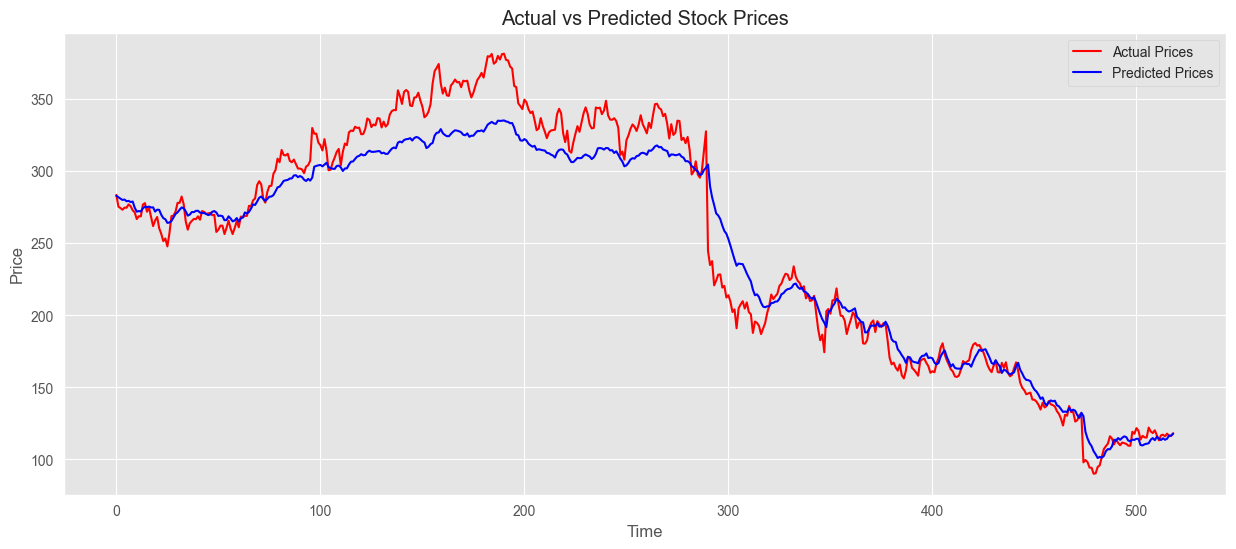

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# # Plot loss curves
# plt.figure(figsize=(10, 6))
# plt.plot(training_losses, label='Training Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.title('Model Loss Over Time')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

In [10]:
# Create model instance
input_dim = len(selected_features)
model = EfficientStockPredictor(input_dim=input_dim)

# Print the model
print(model)


EfficientStockPredictor(
  (input_projection): Linear(in_features=14, out_features=128, bias=True)
  (input_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (output_norm): LayerNorm((128,), eps=1e-05, elemen

In [ ]:
# from sklearn.metrics import mean_squared_error

# # Permutation Feature Importance
# def permutation_feature_importance(model, X_val, y_val, feature_names):
#     baseline_score = mean_squared_error(y_val, model(X_val).squeeze().detach().numpy())
#     importance_scores = {}

#     for i, feature in enumerate(feature_names):
#         X_val_perturbed = X_val.clone()
#         X_val_perturbed[:, :, i] = X_val_perturbed[:, :, i][torch.randperm(X_val_perturbed.size(0))]
        
#         perturbed_score = mean_squared_error(y_val, model(X_val_perturbed).squeeze().detach().numpy())
#         importance_scores[feature] = baseline_score - perturbed_score  # Higher drop = more important

#     # Normalize importance scores
#     total_importance = sum(importance_scores.values())
#     for feature in importance_scores:
#         importance_scores[feature] /= total_importance

#     return importance_scores

# # Example usage
# feature_names = selected_features  # List of feature names
# importance_scores = permutation_feature_importance(model, X_val, y_val, feature_names)
# print("Feature Importance Scores:", importance_scores)

# # Most Important Features:
# # EMA for 5 days (0.239)
# # Open (0.213)
# # MA for 5 days (0.134)
# # MA for 10 days (0.134)
# # Low (0.080)

# # Less Important Features:
# # Volume (-0.0006)
# # MA for 20 days (-0.009)
# # EMA for 50 days (-0.0003)

# # Moderately Important Features:
# # High (0.038)
# # RSI_14 (0.039)
# # EMA for 10 days (0.032)
# # EMA for 20 days (0.041)
# # MA for 50 days (0.051)

# # Most important features:
# # selected_features = [
# #     'close',
# #     'Open',
# #     'Low',
# #     'EMA for 5 days',
# #     'MA for 5 days',
# #     'MA for 10 days',
# #     'High',
# #     'RSI_14'
# # ]

In [ ]:
# Save model after training
def save_model(model, path='stock_predictor_model.pth'):
    """
    Save the EfficientStockPredictor model architecture and weights.
    
    Args:
        model (EfficientStockPredictor): The model to save
        path (str): Path where to save the model
    """
    # Extract architecture parameters from the model
    d_model = model.input_projection.out_features
    nhead = model.transformer_encoder.layers[0].self_attn.num_heads
    num_encoder_layers = len(model.transformer_encoder.layers)
    hidden_dim = model.lstm.hidden_size

    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': model.input_projection.in_features,
        'architecture': {
            'd_model': d_model,
            'nhead': nhead,
            'num_encoder_layers': num_encoder_layers,
            'hidden_dim': hidden_dim
        }
    }, path)
    print(f"Model saved to {path}")


In [ ]:
# save the model
save_model(model)

Model saved to stock_predictor_model.pth


In [ ]:
# # Save the model
# torch.save(model.state_dict(), 'stock_predictor_model.pth')

In [ ]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV 
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    mse = round(mse, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")

In [ ]:
save_metrics(
    test_label=actual_prices,
    predicted=predictions,
    model_name="Transformer-LSTM",
    stock_name="META"  
)


Metrics for Transformer-LSTM on META:
Mean Squared Error (MSE): 278.6256
Root Mean Squared Error (RMSE): 16.6921
Mean Absolute Error (MAE): 12.5904
Mean Absolute Percentage Error (MAPE): 4.9623%
R² Score: 0.9600


In [ ]:
def save_prediction_errors(predictions, actual_values, model_name, stock_name):
    """
    Save prediction errors for error distribution analysis
    """
    # Calculate errors
    errors = predictions - actual_values
    
    # Save to numpy file
    filename = f'errors_{model_name}_{stock_name}.npy'
    np.save(filename, errors)
    
    print(f"Saved prediction errors to {filename}")

# Save the errors
save_prediction_errors(
    predictions=predictions,
    actual_values=actual_prices,
    model_name="Transformer-LSTM",
    stock_name="META" 
)

Saved prediction errors to errors_Transformer-LSTM_META.npy


: 

In [ ]:
# Plot learning rate
plt.figure(figsize=(10, 6))
plt.plot(history['learning_rates'])
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')  # Log scale makes step changes clearer
plt.grid(True)
plt.savefig('learning_rate_schedule.png')
plt.show()

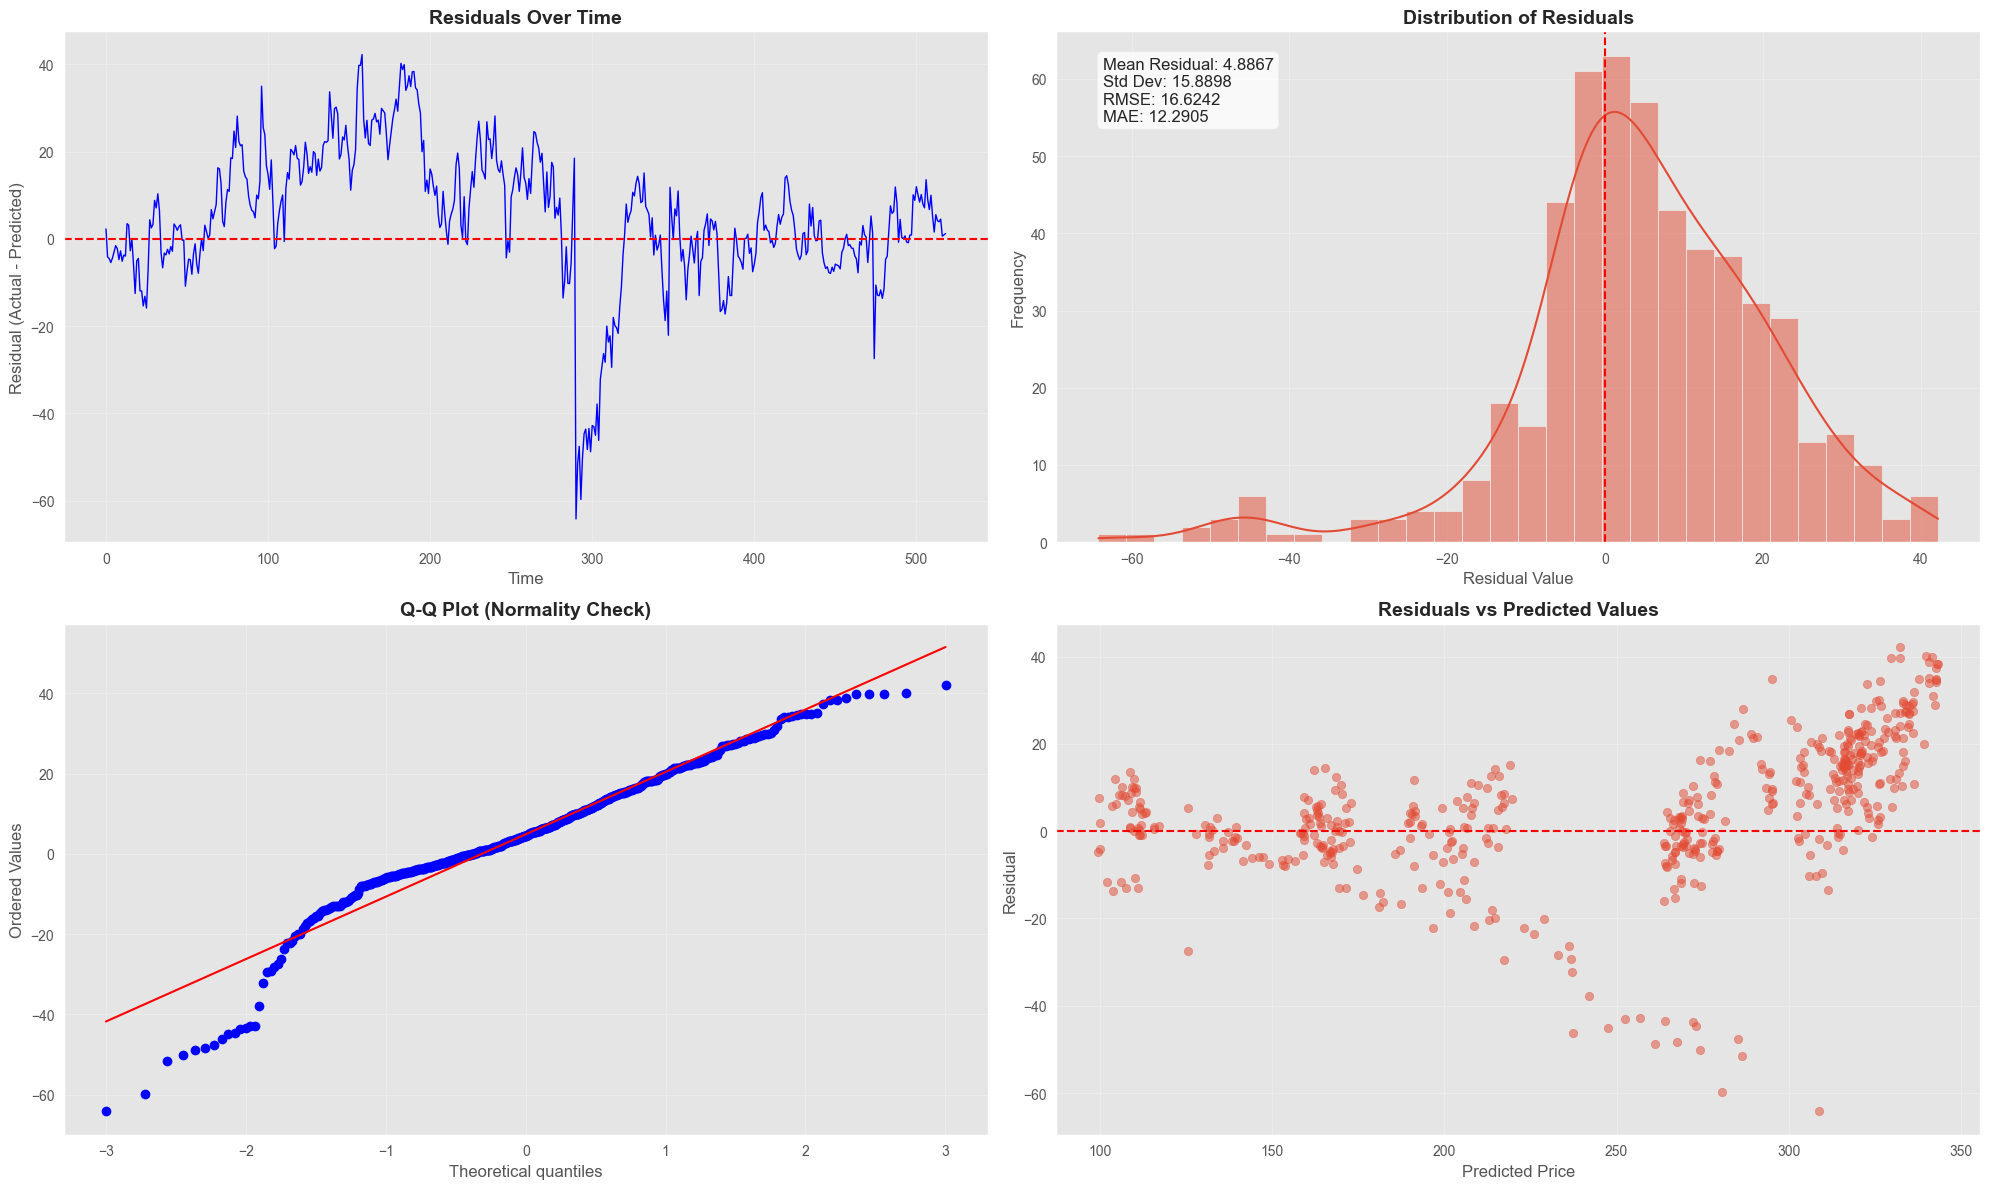

In [8]:
# Assuming you have already:
# 1. Trained your Transformer-LSTM model
# 2. Generated predictions in 'predictions_original_scale'
# 3. Have actual values in 'actual_prices'

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

# Calculate residuals
residuals = actual_prices - predictions

# Create figure
plt.figure(figsize=(20, 12))

# 1. Residuals over time
plt.subplot(2, 2, 1)
plt.plot(residuals, 'b-', linewidth=1)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, alpha=0.3)

# 2. Histogram of residuals
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 3. Q-Q plot for normality assessment
plt.subplot(2, 2, 3)
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted values
plt.subplot(2, 2, 4)
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

# Add summary statistics textbox
stats_text = (
    f"Mean Residual: {np.mean(residuals):.4f}\n"
    f"Std Dev: {np.std(residuals):.4f}\n"
    f"RMSE: {np.sqrt(np.mean(residuals**2)):.4f}\n"
    f"MAE: {np.mean(np.abs(residuals)):.4f}"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.subplot(2, 2, 2)
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('transformer_lstm_residuals.png', dpi=300)
plt.show()